# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

## Data
CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


CIFAR-10 Dataset: 171MB [02:47, 1.02MB/s]                              


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # total_features*RGB*H*W
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1) #(len, 32, 32, 3)
    labels = batch['labels']
    
    return features, labels

In [3]:


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

In [4]:


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1) #10%

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_testing.p')

In [5]:

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


In [7]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 5
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

# Display Image


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 100:
Image - Min Value: 5 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


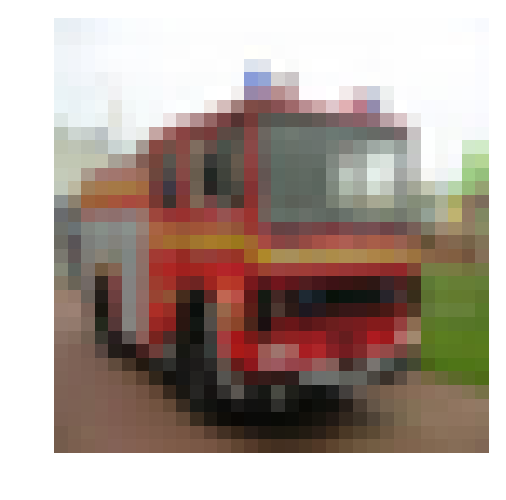

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 5 #1-5
sample_id = 100 #1-10,000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

# Solution 

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [9]:
# Min-Max normalizer
# z-normalizer (not using now)

import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = np.array(x)
    x_max = np.max(x)
    x_min = np.min(x)
    output = (x - x_min)/(x_max - x_min)
    return output


### One-hot encode
The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  


In [10]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(range(10))


def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    #print(lb.transform(x))
    return lb.transform(x) #0-9


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [11]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [12]:

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [13]:
valid_features[0], valid_labels[0]

(array([[[0.54901961, 0.49019608, 0.45098039],
         [0.57254902, 0.50980392, 0.47843137],
         [0.56078431, 0.49803922, 0.47843137],
         ...,
         [0.66666667, 0.56862745, 0.51372549],
         [0.69019608, 0.58823529, 0.5254902 ],
         [0.66666667, 0.57647059, 0.52156863]],
 
        [[0.4745098 , 0.42352941, 0.50588235],
         [0.50980392, 0.4627451 , 0.54509804],
         [0.5254902 , 0.4745098 , 0.56078431],
         ...,
         [0.63921569, 0.55294118, 0.61568627],
         [0.66666667, 0.57254902, 0.63137255],
         [0.66666667, 0.58039216, 0.63137255]],
 
        [[0.59607843, 0.54509804, 0.68235294],
         [0.61568627, 0.56862745, 0.70196078],
         [0.60784314, 0.56078431, 0.68627451],
         ...,
         [0.69411765, 0.60392157, 0.75686275],
         [0.70980392, 0.61176471, 0.76078431],
         [0.71764706, 0.62745098, 0.76078431]],
 
        ...,
 
        [[0.49019608, 0.43137255, 0.4       ],
         [0.50588235, 0.43921569, 0.40392

In [14]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape = (None, image_shape[0], image_shape[1], image_shape[2]), name = 'x')
    # None indicates that the first dimension, corresponding to the batch size, can be of any size.


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape = (None, n_classes), name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, shape = (None), name = 'keep_prob')


tf.reset_default_graph()


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    shape_of_x_tensor = x_tensor.get_shape().as_list()
    F_W = tf.Variable(tf.truncated_normal([conv_ksize[0] ,conv_ksize[1] ,shape_of_x_tensor[-1] ,conv_num_outputs] 
                                          ,dtype=tf.float32, stddev=0.2))
    F_b = tf.Variable(tf.zeros([conv_num_outputs]  ,dtype=tf.float32))
    
    strides_conv = [1, conv_strides[0], conv_strides[1], 1]
    padding = 'SAME' #or VALID
    
    output = tf.nn.conv2d(x_tensor, F_W, strides_conv, padding)
    output = tf.nn.bias_add(output, F_b)
    
    output = tf.nn.relu(output)
    
    #pooling
    ksize_maxpool = [1, pool_ksize[0], pool_ksize[1], 1]
    strides_maxpool = [1, pool_strides[0], pool_strides[1], 1]
    output = tf.nn.max_pool(output, ksize_maxpool, strides_maxpool, padding)
    
    return output 


#https://stackoverflow.com/questions/34642595/tensorflow-strides-argument

### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). You can use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer.

In [16]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    shape = x_tensor.get_shape().as_list()
    flat_dim = shape[1]*shape[2]*shape[3]
    output = tf.reshape(x_tensor, [-1, flat_dim])
    return output


In [17]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    shape = x_tensor.get_shape().as_list()
    weights= tf.Variable( tf.truncated_normal([shape[1], num_outputs] ,dtype=tf.float32, stddev=0.2))
    biases = tf.Variable(tf.zeros([num_outputs]  ,dtype=tf.float32))
    
    out = tf.add(tf.matmul(x_tensor, weights), biases)
    out = tf.nn.relu(out)
    return out


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

Note: Activation, softmax, or cross entropy shouldn't be applied to this.

In [18]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    shape = x_tensor.get_shape().as_list()
    weights= tf.Variable(tf.truncated_normal([shape[1], num_outputs] ,dtype=tf.float32, stddev=0.2))
    biases = tf.Variable(tf.zeros([num_outputs]  ,dtype=tf.float32))
    out = tf.add(tf.matmul(x_tensor, weights), biases)
    # No Activation function
    return out


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [19]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """

    out = conv2d_maxpool(x, conv_num_outputs = 16, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))
    out = conv2d_maxpool(out, conv_num_outputs = 32, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))
    out = conv2d_maxpool(out, conv_num_outputs = 64, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))

    # Function Definition from Above:
    out = flatten(out)
    

    out = fully_conn(out, num_outputs = 64)
    out = tf.nn.dropout(out, keep_prob)
    out = fully_conn(out, num_outputs = 32)
    out = tf.nn.dropout(out, keep_prob)
    out = fully_conn(out, num_outputs = 16)
    #    Set this to the number of classes
    # Function Definition from Above:
    
    out = output(out, num_outputs = 10)

    return out


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Input placeholders
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost) #GD, SGD

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [20]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch,keep_prob:keep_probability})


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [21]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    train_acc = sess.run(accuracy, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    train_cost = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    print('Cost {::>8.5f}, Accuracy on Training {:.4f} -'
                  'Validation Accuracy: {:.4f}'.format(
                train_cost,
                train_acc,
                valid_acc))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [22]:
epochs = 50 # 100
batch_size = 256  #(2^n): 512, 
keep_probability = 0.6 #0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [23]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Cost :2.27843, Accuracy on Training 0.1750 -Validation Accuracy: 0.1420
Epoch  2, CIFAR-10 Batch 1:  Cost :2.23821, Accuracy on Training 0.2000 -Validation Accuracy: 0.1604
Epoch  3, CIFAR-10 Batch 1:  Cost :2.21264, Accuracy on Training 0.2000 -Validation Accuracy: 0.1726
Epoch  4, CIFAR-10 Batch 1:  Cost :2.18468, Accuracy on Training 0.2750 -Validation Accuracy: 0.1914
Epoch  5, CIFAR-10 Batch 1:  Cost :2.18108, Accuracy on Training 0.2750 -Validation Accuracy: 0.2072
Epoch  6, CIFAR-10 Batch 1:  Cost :2.15611, Accuracy on Training 0.2750 -Validation Accuracy: 0.2374
Epoch  7, CIFAR-10 Batch 1:  Cost :2.10160, Accuracy on Training 0.2500 -Validation Accuracy: 0.2488
Epoch  8, CIFAR-10 Batch 1:  Cost :2.04582, Accuracy on Training 0.3250 -Validation Accuracy: 0.2942
Epoch  9, CIFAR-10 Batch 1:  Cost :1.96889, Accuracy on Training 0.3000 -Validation Accuracy: 0.3090
Epoch 10, CIFAR-10 Batch 1:  Cost :1.87499, Accu

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [24]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Cost :2.28800, Accuracy on Training 0.2500 -Validation Accuracy: 0.1278
Epoch  1, CIFAR-10 Batch 2:  Cost :2.24536, Accuracy on Training 0.2750 -Validation Accuracy: 0.1578
Epoch  1, CIFAR-10 Batch 3:  Cost :2.23130, Accuracy on Training 0.2000 -Validation Accuracy: 0.1896
Epoch  1, CIFAR-10 Batch 4:  Cost :2.18611, Accuracy on Training 0.1750 -Validation Accuracy: 0.1838
Epoch  1, CIFAR-10 Batch 5:  Cost :2.12127, Accuracy on Training 0.3000 -Validation Accuracy: 0.2174
Epoch  2, CIFAR-10 Batch 1:  Cost :2.20576, Accuracy on Training 0.1750 -Validation Accuracy: 0.2374
Epoch  2, CIFAR-10 Batch 2:  Cost :1.96757, Accuracy on Training 0.3750 -Validation Accuracy: 0.2630
Epoch  2, CIFAR-10 Batch 3:  Cost :1.87728, Accuracy on Training 0.2250 -Validation Accuracy: 0.2824
Epoch  2, CIFAR-10 Batch 4:  Cost :1.83086, Accuracy on Training 0.3750 -Validation Accuracy: 0.2780
Epoch  2, CIFAR-10 Batch 5:  Cost :1.85834, Accuracy on Training 0.3750 -Valida

Epoch 17, CIFAR-10 Batch 2:  Cost :0.78348, Accuracy on Training 0.6750 -Validation Accuracy: 0.5768
Epoch 17, CIFAR-10 Batch 3:  Cost :0.72390, Accuracy on Training 0.6750 -Validation Accuracy: 0.5688
Epoch 17, CIFAR-10 Batch 4:  Cost :0.83778, Accuracy on Training 0.7000 -Validation Accuracy: 0.5788
Epoch 17, CIFAR-10 Batch 5:  Cost :0.82863, Accuracy on Training 0.7500 -Validation Accuracy: 0.5828
Epoch 18, CIFAR-10 Batch 1:  Cost :0.84177, Accuracy on Training 0.6500 -Validation Accuracy: 0.5878
Epoch 18, CIFAR-10 Batch 2:  Cost :0.75746, Accuracy on Training 0.7750 -Validation Accuracy: 0.5908
Epoch 18, CIFAR-10 Batch 3:  Cost :0.66199, Accuracy on Training 0.7500 -Validation Accuracy: 0.5764
Epoch 18, CIFAR-10 Batch 4:  Cost :0.79744, Accuracy on Training 0.7250 -Validation Accuracy: 0.5896
Epoch 18, CIFAR-10 Batch 5:  Cost :0.75997, Accuracy on Training 0.7500 -Validation Accuracy: 0.5896
Epoch 19, CIFAR-10 Batch 1:  Cost :0.80848, Accuracy on Training 0.7250 -Validation Accurac

Epoch 33, CIFAR-10 Batch 3:  Cost :0.45958, Accuracy on Training 0.9000 -Validation Accuracy: 0.6398
Epoch 33, CIFAR-10 Batch 4:  Cost :0.50475, Accuracy on Training 0.9250 -Validation Accuracy: 0.6420
Epoch 33, CIFAR-10 Batch 5:  Cost :0.49380, Accuracy on Training 0.9000 -Validation Accuracy: 0.6264
Epoch 34, CIFAR-10 Batch 1:  Cost :0.58074, Accuracy on Training 0.7750 -Validation Accuracy: 0.6446
Epoch 34, CIFAR-10 Batch 2:  Cost :0.49338, Accuracy on Training 0.8500 -Validation Accuracy: 0.6310
Epoch 34, CIFAR-10 Batch 3:  Cost :0.41199, Accuracy on Training 0.9250 -Validation Accuracy: 0.6446
Epoch 34, CIFAR-10 Batch 4:  Cost :0.49283, Accuracy on Training 0.9000 -Validation Accuracy: 0.6394
Epoch 34, CIFAR-10 Batch 5:  Cost :0.46060, Accuracy on Training 0.9000 -Validation Accuracy: 0.6476
Epoch 35, CIFAR-10 Batch 1:  Cost :0.54014, Accuracy on Training 0.7750 -Validation Accuracy: 0.6448
Epoch 35, CIFAR-10 Batch 2:  Cost :0.45963, Accuracy on Training 0.8500 -Validation Accurac

Epoch 49, CIFAR-10 Batch 4:  Cost :0.32135, Accuracy on Training 0.9750 -Validation Accuracy: 0.6552
Epoch 49, CIFAR-10 Batch 5:  Cost :0.26282, Accuracy on Training 1.0000 -Validation Accuracy: 0.6666
Epoch 50, CIFAR-10 Batch 1:  Cost :0.46195, Accuracy on Training 0.8250 -Validation Accuracy: 0.6488
Epoch 50, CIFAR-10 Batch 2:  Cost :0.34141, Accuracy on Training 0.9250 -Validation Accuracy: 0.6572
Epoch 50, CIFAR-10 Batch 3:  Cost :0.27233, Accuracy on Training 0.9500 -Validation Accuracy: 0.6708
Epoch 50, CIFAR-10 Batch 4:  Cost :0.28862, Accuracy on Training 0.9750 -Validation Accuracy: 0.6632
Epoch 50, CIFAR-10 Batch 5:  Cost :0.28185, Accuracy on Training 0.9750 -Validation Accuracy: 0.6594



The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be the final accuracy. 

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6564453125



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


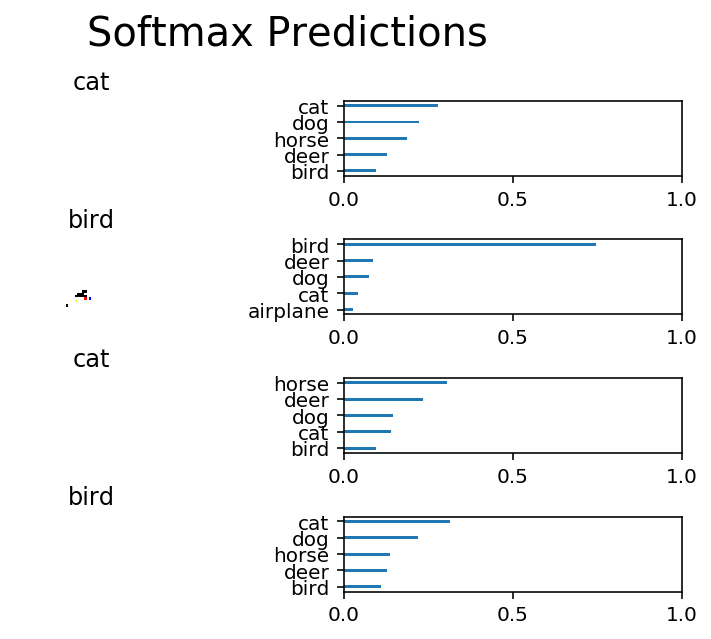

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 5

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_testing.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()